# Deep Learining Project 2
###    Wojciech Wieczorek 145465
###    Jerzy Łukaszewicz 145458

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Reshape, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

## Generating data

We start by creating 50000 candies with the function provided in task.

In [3]:
np.random.seed(42)

In [4]:
n = 50000

Errors of 5 classes can be detected. We use random seed to reproduce our results.

In [5]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    
xl = np.array(xl)
yl = np.array(yl).astype(int)

<ipython-input-6-81381250e1fb>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xl = np.array(xl)


## Samples of data

Below we can see and examples of raw time series.

[0 0 0 0 1]


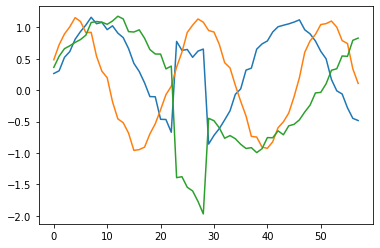

[0 0 0 1 1]


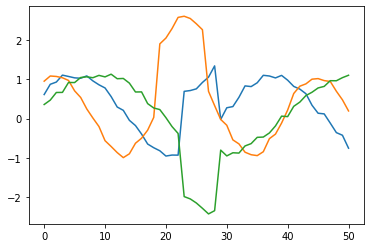

[0 0 0 0 0]


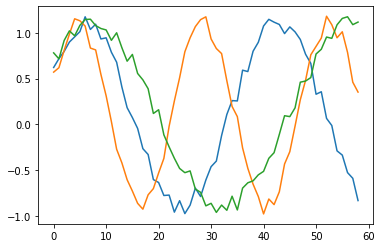

In [7]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

## Data preprocessing

We split the data into training, validation and testing sets.

#### Split sizes: 
* 80% - train
* 10% - validation
* 10% - test

In [8]:
nopad_X_train, nopad_X_test, y_train, y_test = train_test_split(xl, yl, test_size=0.2, random_state=42)
nopad_X_test, nopad_X_val, y_test, y_val = train_test_split(nopad_X_test, y_test, test_size=0.5, random_state=42)

There is a problem with sequences having different lengths. We solve it by padding shorter sequences with zeros, making it so that all sequences have length 60.

In [9]:
X_train = pad_sequences(nopad_X_train, padding="post", dtype='float32', maxlen=60)
X_test = pad_sequences(nopad_X_test, padding="post", dtype='float32', maxlen=60)
X_val = pad_sequences(nopad_X_val, padding="post", dtype='float32', maxlen=60)

## Model no. 1

Our first model takes whole sequences (of size 60 by 6) as an input and outputs vector of probabilities for 5 error classes occurring in data.

The processing is conducted in 4 layers of LSTM.
After that we use Dense layer of size 5 to detect error class of a given sequence. 
After some experiments with different metrics and loss functions, we settled on BinaryAccuracy as metrics and BinaryCrossentropy as loss function.

In [33]:
model = Sequential()
model.add(Input(shape=(None, 3)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(5,activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 64)          17408     
                                                                 
 lstm_9 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_10 (LSTM)              (None, None, 32)          8320      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


We initiate training on 25 epochs with early stopping condition (to prevent overfitting) checking how it behaves on validation set.

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train,y_train, epochs=25, validation_data = (X_val, y_val), batch_size=64, callbacks=[callback])

Epoch 1/25
625/625 [==============================] - 34s 47ms/step - loss: 0.3606 - binary_accuracy: 0.8438 - val_loss: 0.2708 - val_binary_accuracy: 0.8888
Epoch 2/25
625/625 [==============================] - 29s 46ms/step - loss: 0.2403 - binary_accuracy: 0.9004 - val_loss: 0.2111 - val_binary_accuracy: 0.9120
Epoch 3/25
625/625 [==============================] - 29s 46ms/step - loss: 0.2091 - binary_accuracy: 0.9126 - val_loss: 0.1947 - val_binary_accuracy: 0.9172
Epoch 4/25
625/625 [==============================] - 29s 47ms/step - loss: 0.1855 - binary_accuracy: 0.9220 - val_loss: 0.1686 - val_binary_accuracy: 0.9301
Epoch 5/25
625/625 [==============================] - 29s 47ms/step - loss: 0.1679 - binary_accuracy: 0.9303 - val_loss: 0.1672 - val_binary_accuracy: 0.9310
Epoch 6/25
625/625 [==============================] - 29s 46ms/step - loss: 0.1600 - binary_accuracy: 0.9333 - val_loss: 0.1691 - val_binary_accuracy: 0.9316
Epoch 7/25
625/625 [==============================] 

In [36]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 2s 12ms/step - loss: 0.0286 - binary_accuracy: 0.9918


[0.028605228289961815, 0.991840124130249]

Our model evaluation on test set achieves over 99% accuracy.

Here we provide an example of simple prediction for one random time series to show it visually. If probability is greater than 0.5 then we treat it as a match.

In [37]:
model.predict(np.array([X_test[11]])).round()

array([[0., 0., 1., 0., 0.]], dtype=float32)

We also provide true label to check for the correctness.

[0 0 1 0 0]


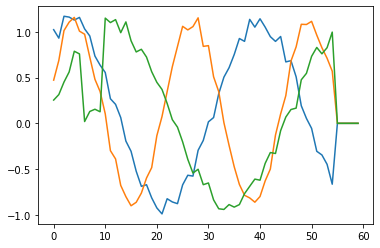

In [38]:
plt.plot(X_test[11])
print(y_test[11])

As we can see, the prediction was good.

## Model no. 2

In this model we go step further, we predict error class in a given section of a sequence which will allow us to detect exact place of the defects.

We use model no. 1 as TimeDistributed submodel which will predict errors on subsequences of lenght 10. Each submodel returns vector of probabilities for corresponding subsequence which we then feed to max-pooling layer. We also use the same metrics and loss functions as before.

In [39]:
model = Sequential()
model.add(Input(shape=(None, 3)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(5,activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, None, 64)          17408     
                                                                 
 lstm_13 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_14 (LSTM)              (None, None, 32)          8320      
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [40]:
pred_model = Sequential()
pred_model.add(Reshape((-1, 10, 3), input_shape=(60, 3)))
pred_model.add(TimeDistributed(model))
pred_model.add(GlobalMaxPool1D())
pred_model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])
pred_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 5)             46629     
 tributed)                                                       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


Now the model get good results even faster than model no. 1, so there is no need for more than 10 epochs of learning.

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
pred_model.fit(X_train,y_train, epochs=10, validation_data = (X_val, y_val), batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 24s 28ms/step - loss: 0.4264 - binary_accuracy: 0.8154 - val_loss: 0.3412 - val_binary_accuracy: 0.8549
Epoch 2/10
625/625 [==============================] - 16s 25ms/step - loss: 0.3170 - binary_accuracy: 0.8663 - val_loss: 0.2821 - val_binary_accuracy: 0.8848
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2333 - binary_accuracy: 0.9061 - val_loss: 0.1923 - val_binary_accuracy: 0.9252
Epoch 4/10
625/625 [==============================] - 16s 25ms/step - loss: 0.1583 - binary_accuracy: 0.9396 - val_loss: 0.0968 - val_binary_accuracy: 0.9717
Epoch 5/10
625/625 [==============================] - 16s 25ms/step - loss: 0.0677 - binary_accuracy: 0.9797 - val_loss: 0.0460 - val_binary_accuracy: 0.9870
Epoch 6/10
625/625 [==============================] - 16s 25ms/step - loss: 0.0393 - binary_accuracy: 0.9891 - val_loss: 0.0347 - val_binary_accuracy: 0.9897
Epoch 7/10
625/625 [==============================] 

To obtain the probabilities of defect classes for each subsequence, we take the output of time distributed layer. The result is tensor of size 6 by 5 (number of subsequences by number 5 defect classes).

In [43]:
model_detect = Model(inputs=pred_model.layers[0].input, outputs=pred_model.layers[-2].output)
model_detect.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2_input (InputLayer  [(None, 60, 3)]          0         
 )                                                               
                                                                 
 reshape_2 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 5)             46629     
 tributed)                                                       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


We plot the prediction with marked sequences where the defects occur. Each subsequence of length 10 has its own color, and we label what defects were predicted within their boundaries.

True label of defects:  [0 0 0 1 0]


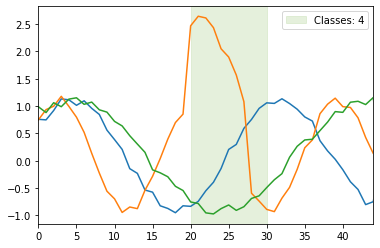

True label of defects:  [0 0 0 1 0]


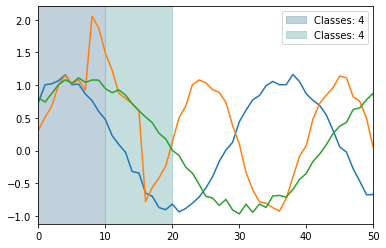

True label of defects:  [0 1 0 0 0]


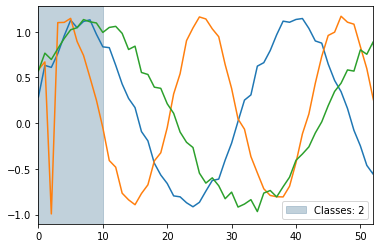

True label of defects:  [0 0 0 0 1]


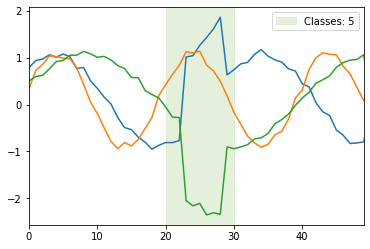

True label of defects:  [0 0 0 1 0]


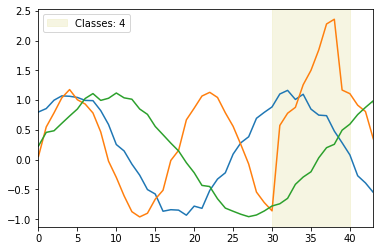

True label of defects:  [1 0 0 0 0]


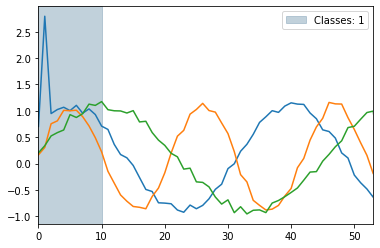

True label of defects:  [0 0 1 0 1]


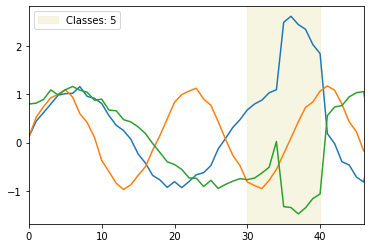

True label of defects:  [1 0 0 0 1]


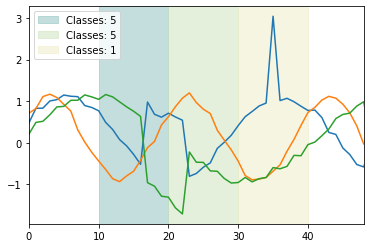

True label of defects:  [0 0 1 1 0]


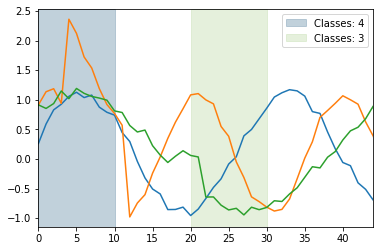

True label of defects:  [1 0 0 0 0]


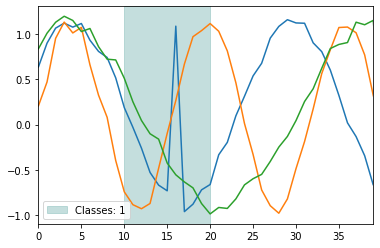

In [48]:
colors = ['#85A4B9', '#8BBFBC', '#CCE2BA', '#EFEDC6', '#D2BC99', '#D6CBBB']

data = X_test[15:25]
pom = nopad_X_test[15:25]
labelY = y_test[15:25]
perdictions = model_detect.predict(data)

for idx, p in enumerate(perdictions):
    plt.figure()
    plt.plot(data[idx])
    for i in range(6):
        classes = ""
        for j in range(5):
            if p[i, j].round() > 0:
                classes += str(j+1) + ', '
        
        classes = classes.strip(', ')
        
        if len(classes) > 0:
            plt.axvspan(i*10, i*10+10, color=colors[i], alpha=0.5, label="Classes: " + classes)
    print("True label of defects: ",labelY[idx])
    plt.xlim([0, len(pom[idx])-1])
    plt.legend()
    plt.show()